In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
# Util function to calculate how frequently words appear in the text
def word_frequencies(text, include_stop=True):
    
    # Build list of words
    # Strip out punctuation and, optionally, stop_words
    words = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            words.append(token.lemma_)
    
    # Build and return a Counter object containing work counts
    return Counter(words)

In [3]:
# Sentences
sentence1 = "The best Monty Python sketch is the one about the dead parrot, I laughed so hard."
sentence2 = "I laugh when I think about Python's Ministry of Silly Walks sketch, it is funny, funny, funny, the best!"
sentence3 = "Chocolate is the best ice cream dessert topping, with a great taste."
sentence4 = "The Lumberjack Song is the funniest Monty Python bit: I can't think of it without laughing."
sentence5 = "I would rather put strawberries on my ice cream for dessert, they have the best taste."
sentence6 = "The taste of caramel is a fantastic accompaniment to tasty mint ice cream."

In [4]:
# Converting text to lowercase to properly grab stopwords
sentence1 = sentence1.lower()
sentence2 = sentence2.lower()
sentence3 = sentence3.lower()
sentence4 = sentence4.lower()
sentence5 = sentence5.lower()
sentence6 = sentence6.lower()

In [5]:
# Loading into spacy
nlp = spacy.load('en')
sent1_doc = nlp(sentence1)
sent2_doc = nlp(sentence2)
sent3_doc = nlp(sentence3)
sent4_doc = nlp(sentence4)
sent5_doc = nlp(sentence5)
sent6_doc = nlp(sentence6)

In [6]:
# Grabbing word frequencies by using utility function above
sent1_freq = word_frequencies(sent1_doc, include_stop=False).most_common()
sent2_freq = word_frequencies(sent2_doc, include_stop=False).most_common()
sent3_freq = word_frequencies(sent3_doc, include_stop=False).most_common()
sent4_freq = word_frequencies(sent4_doc, include_stop=False).most_common()
sent5_freq = word_frequencies(sent5_doc, include_stop=False).most_common()
sent6_freq = word_frequencies(sent6_doc, include_stop=False).most_common()

# Initializing term document matrix with columns labelled for each document
tdm = pd.DataFrame(columns=['1', '2', '3', '4', '5', '6'])

# Setting index to all words in all documents
index = []
total_freq = [sent1_freq, sent2_freq, sent3_freq, sent4_freq, sent5_freq, sent6_freq]
for sents in total_freq:
    index = index + [pair[0] for pair in sents]

tdm['words'] = list(set(index))
tdm = tdm.set_index(['words'])
tdm = tdm.fillna(0)

# Populating term document matrix with word occurences
for sents in total_freq:
    for pair in sents:
        tdm.at[pair[0], str(total_freq.index(sents) + 1)] = pair[1]

# Finding document frequency and collection frequency of each word
for index, row in tdm.iterrows():
    tdm.at[index, 'df'] = len(total_freq) - list(row).count(0)
    tdm.at[index, 'cf'] = sum(row)

# Removing all words that only appear in 1 sentence
tdm = tdm.drop(tdm[tdm['cf'] < 2].index, axis=0)

In [7]:
# Computing inverse document frequency value
tdm['idf'] = np.log2(len(total_freq) / tdm['df'])

In [8]:
# Initializing term frequency weights data frame (tf-idd)
tf_idf = pd.DataFrame(columns=['1', '2', '3', '4', '5', '6'], index=tdm.index)

# Computing tf_idf scores
for index, row in tdm.iterrows():
    row = list(row[:'6'])
    tf_idf.loc[index] = [tf * tdm.at[index, 'idf'] for tf in row]

In [9]:
# Final tf_idf matrix
tf_idf

,1,2,3,4,5,6
words,,,,,,
laugh,1,1,0,1,0,0
taste,0,0,1,0,1,1
dessert,0,0,1.58496,0,1.58496,0
sketch,1.58496,1.58496,0,0,0,0
cream,0,0,1,0,1,1
good,0.584963,0.584963,0.584963,0,0.584963,0
monty,1.58496,0,0,1.58496,0,0
think,0,1.58496,0,1.58496,0,0
funny,0,7.75489,0,0,0,0


In [10]:
# Latent Semantic Analysis (LSA)

import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('punkt')
import re
from sklearn.model_selection import train_test_split

# Reading in data, this time in the form of paragraphs
emma = gutenberg.paras('austen-emma.txt')

# Processing
emma_paras = []
for paragraph in emma:
    para = paragraph[0]
    
    # Removing the double dash from all words
    para = [re.sub(r'--', '', word) for word in para]
    
    # Forming each paragraph into a string and adding it to the list of strings
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/EricSirinian/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/EricSirinian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [23]:
# Using sklearn's tfidf function for heavy lifting (has long list of stop words so reduction will be necessary later)

from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # Drop words that occur in more than half the paragraphs
                             min_df=2,   # Only use words that appear at least twice
                             stop_words = 'english',
                             lowercase=True, # Convert everything to lower case
                             use_idf=True, # Inverse document frequencies for weighting
                             norm=u'l2', # Applies correction factor so longer/shorter paragaphs are treated equally
                             smooth_idf=True # Adds 1 to all df's (as if extra doc existed that used every word once; 
                                             # prevents divide by zero errors)
                            )

# Apply vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of features: {}'.format(emma_paras_tfidf.get_shape()[1]))

# Split data
X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

# Reshape vectorizer outpu into something readable
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Number of paragraphs
n = X_train_tfidf_csr.shape[0]

# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0, n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
# Note log2 of 1 is 0, so a tf-idf score of 0 means the word was present once in that sentence
print('Original sentence: ', X_train[5])
print('Tf_idf vector: ', tfidf_bypara[5])

Number of features: 1948
Original sentence:  A very few minutes more , however , completed the present trial .
Tf_idf vector:  {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [24]:
# Using Singular Value Decomposition (SVD) over PCA because we don't want to mean-center our variables (lose sparsity)
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Our SVD data reducer.  Reducing feature space to 130
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all component: ', total_variance * 100)

# Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component: {}'.format(i))
    print(paras_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all componenet:  45.21927549910548
Component: 0
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
Name: 0, dtype: float64
Component: 1
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.635356
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.577112
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.561101
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                

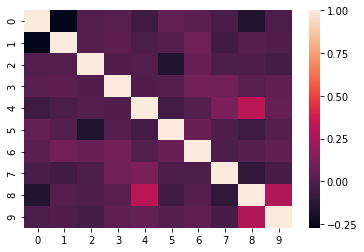

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [25]:
# Computing document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

# Only taking the first 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]

# Making a heatplot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Generating key for plot
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

In [26]:
# Applying LSA model to test set
X_test_tfidf_csr = X_test_tfidf.tocsr()

# Number of paragraphs
n = X_test_tfidf_csr.shape[0]

# List of dictionaries; one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# for each paragraph, lists thier feature words and their tfidf scores
for i,j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf[i, j]
    
print('Originial Sentence:', X_test[5])
print('Tf_idf vector: ', tfidf_bypara[5])

Originial Sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector:  {'resolving': 0.3424390305045805, 'unexceptionable': 0.3196409792117937, 'assure': 0.267729777836069, 'friends': 0.2515333740641343, 'quite': 0.1916471918420347, 'replied': 0.20315405638674577, 'watch': 0.62300800500314, 'elton': 0.16874782424809767, 'pass': 0.28445227585106625, 'really': 0.21963852817625326, 'mrs': 0.14780961753993585}


In [30]:
# Run SVD on test data, project test data
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance* 100)

# Looking at what sorts of paragraphs our solution considers similar; first 5 components
paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component: {}'.format(i))
    print(paras_by_component.iloc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.21927549910548
Component: 0
" Oh !       0.99929
" Oh no !    0.99929
" Oh !       0.99929
" Oh !       0.99929
" Oh !       0.99929
" Oh !       0.99929
" Oh !       0.99929
" Oh !       0.99929
" Oh !       0.99929
" Oh !       0.99929
Name: 0, dtype: float64
Component: 1
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.677203
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then a

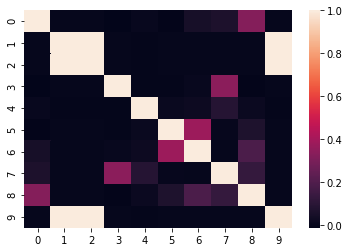

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [29]:
# Compute docmuent similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)

# First 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_test).iloc[0:10, 0:10]

# Making plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Key
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])